In [20]:
import numpy as np
import pandas as pd
import os
import time
import path
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last. 

In [2]:
image_size = (128, 128) 
channels = 3
num_classes = 4

In [3]:
data_path = "/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages"
images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [4]:
data.head()

,image,label
0,/kaggle/input/kaggle-cat-vs-dog-dataset/kaggle...,Dog
1,/kaggle/input/kaggle-cat-vs-dog-dataset/kaggle...,Dog
2,/kaggle/input/kaggle-cat-vs-dog-dataset/kaggle...,Dog
3,/kaggle/input/kaggle-cat-vs-dog-dataset/kaggle...,Dog
4,/kaggle/input/kaggle-cat-vs-dog-dataset/kaggle...,Dog


In [5]:
data['label'].value_counts()

label
Cat    12491
Dog    12470
Name: count, dtype: int64

<Axes: xlabel='label'>

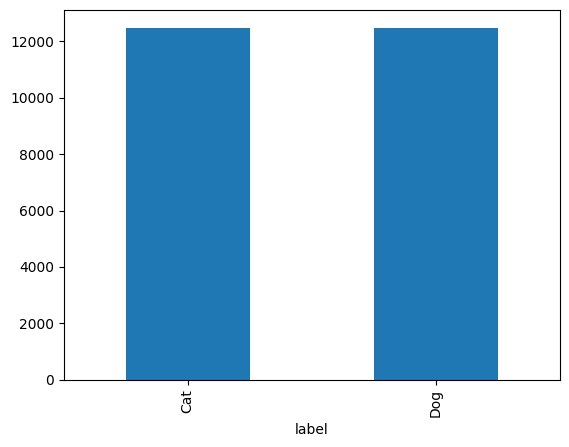

In [10]:
data['label'].value_counts().plot.bar()


In [11]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.60, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [12]:
batch_size = 32
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, 
                                       class_mode='binary', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, 
                                      class_mode='binary', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 14975 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 4991 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 4993 validated image filenames belonging to 2 classes.


In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,786 (49.37 MB)

 Trainable params: 12,941,314 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [22]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.99):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [25]:
cb = myCallback()
history = model.fit(
    train_gen,
    epochs=15,
    batch_size=64,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[cb]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727599370.856500     293 service.cc:145] XLA service 0x7b8b50007980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727599370.856556     293 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727599370.856564     293 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/468 ━━━━━━━━━━━━━━━━━━━━ 2:08:37 17s/step - accuracy: 0.5312 - loss: 1.2162

I0000 00:00:1727599381.074031     293 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 20/468 ━━━━━━━━━━━━━━━━━━━━ 2:40 359ms/step - accuracy: 0.5227 - loss: 2.1648

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


468/468 ━━━━━━━━━━━━━━━━━━━━ 252s 503ms/step - accuracy: 0.5667 - loss: 1.0315 - val_accuracy: 0.5782 - val_loss: 0.7306
Epoch 2/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 107s 197ms/step - accuracy: 0.6322 - loss: 0.6495 - val_accuracy: 0.6153 - val_loss: 0.7453
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 97s 204ms/step - accuracy: 0.6608 - loss: 0.6163 - val_accuracy: 0.7309 - val_loss: 0.5412
Epoch 4/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 93s 195ms/step - accuracy: 0.6932 - loss: 0.5825 - val_accuracy: 0.6345 - val_loss: 0.9381
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 94s 198ms/step - accuracy: 0.7104 - loss: 0.5611 - val_accuracy: 0.7137 - val_loss: 0.5563
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 94s 198ms/step - accuracy: 0.7188 - loss: 0.5478 - val_accuracy: 0.7708 - val_loss: 0.4738
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 95s 200ms/step - accuracy: 0.7392 - loss: 0.5223 - val_accuracy: 0.7037 - val_loss: 0.6858
Epoch 8/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 93s 197ms/step - accuracy: 0.7589 - loss: 0.4986 - v

In [24]:
def plot_history(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    
    plt.show()

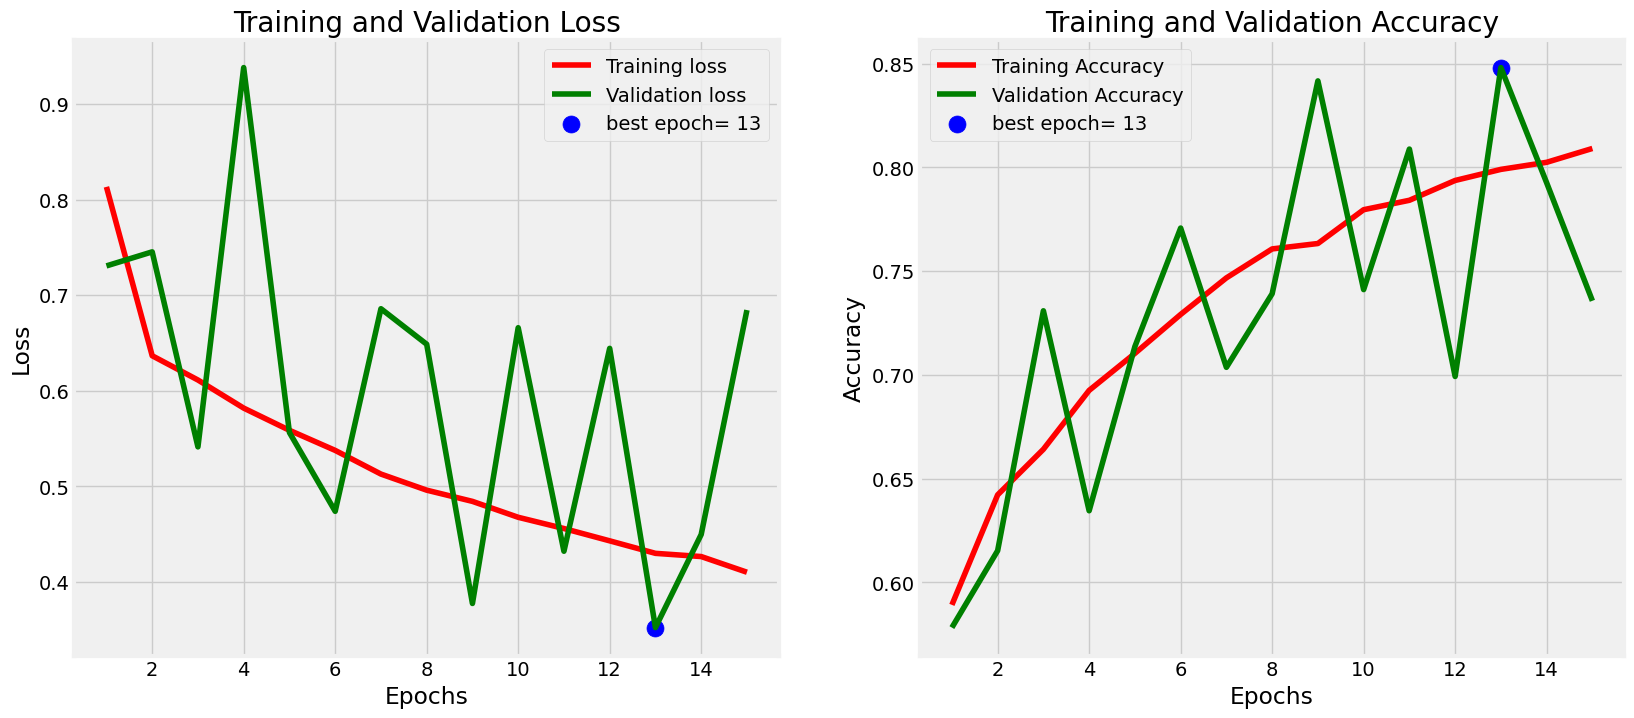

In [26]:
plot_history(history)

In [27]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step


In [33]:
test_gen.class_indices

{'Cat': 0, 'Dog': 1}

In [34]:
from sklearn.metrics import *

print(classification_report(test_gen.classes, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.98      0.79      2499
           1       0.95      0.49      0.65      2494

    accuracy                           0.73      4993
   macro avg       0.81      0.73      0.72      4993
weighted avg       0.80      0.73      0.72      4993



In [36]:
accuracy_score(test_gen.classes, y_pred)

0.7340276386941719

<Axes: >

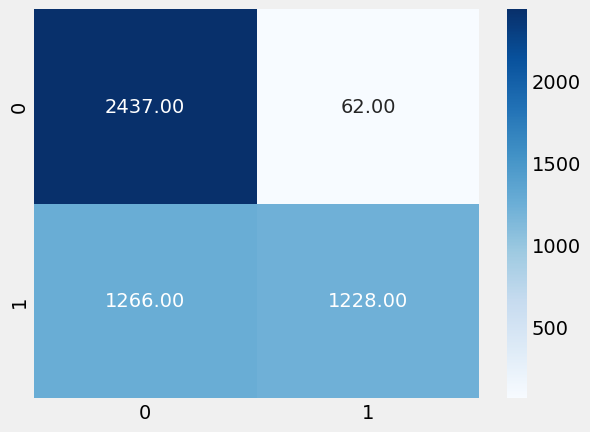

In [37]:
sns.heatmap(confusion_matrix(test_gen.classes,y_pred), cmap='Blues', annot=True, fmt='0.2f')

In [38]:
model.save("model1.h5")

In [42]:
import cv2
def predict_image(model, img):
  img = cv2.imread(img)
  plt.imshow(img)
  plt.show()
  resize = tf.image.resize(img, (128,128))
  yhat = model.predict(np.expand_dims(resize/255, 0))
  max_index = np.argmax(yhat)
  op_d = {0:'Cat',1:'Dog'}
  print(op_d[max_index])

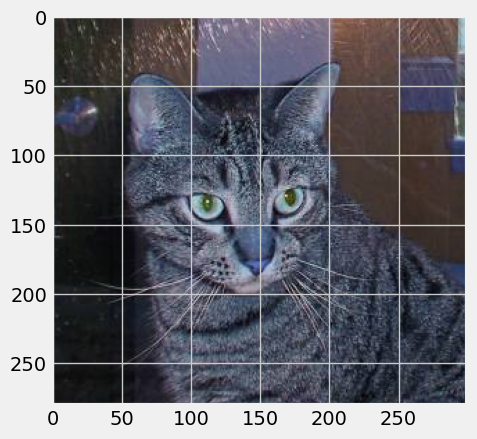

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Cat


In [43]:
predict_image(model,'/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/Cat/1.jpg')

In [48]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,514 (19.50 MB)

 Trainable params: 5,110,530 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [49]:
from time import time
s = time()
cb = myCallback()

history = model.fit(
    train_gen,
    epochs=60,
    batch_size=64,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[cb]
)
et = time()

Epoch 1/60
386/468 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.5836 - loss: 0.8256

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


468/468 ━━━━━━━━━━━━━━━━━━━━ 135s 257ms/step - accuracy: 0.5890 - loss: 0.8076 - val_accuracy: 0.6009 - val_loss: 0.6916
Epoch 2/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 94s 198ms/step - accuracy: 0.6639 - loss: 0.6260 - val_accuracy: 0.7187 - val_loss: 0.5450
Epoch 3/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 109s 229ms/step - accuracy: 0.6912 - loss: 0.5833 - val_accuracy: 0.7337 - val_loss: 0.5381
Epoch 4/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 100s 211ms/step - accuracy: 0.7172 - loss: 0.5442 - val_accuracy: 0.6826 - val_loss: 0.5936
Epoch 5/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 119s 251ms/step - accuracy: 0.7378 - loss: 0.5237 - val_accuracy: 0.7824 - val_loss: 0.4591
Epoch 6/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 101s 212ms/step - accuracy: 0.7556 - loss: 0.4992 - val_accuracy: 0.7912 - val_loss: 0.4512
Epoch 7/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 100s 211ms/step - accuracy: 0.7835 - loss: 0.4611 - val_accuracy: 0.8159 - val_loss: 0.4143
Epoch 8/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.7957 - loss: 0.435

In [50]:
print(et-s)

2254.379696369171


In [52]:
scores = model.evaluate(test_gen)

157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step - accuracy: 0.9291 - loss: 0.1853


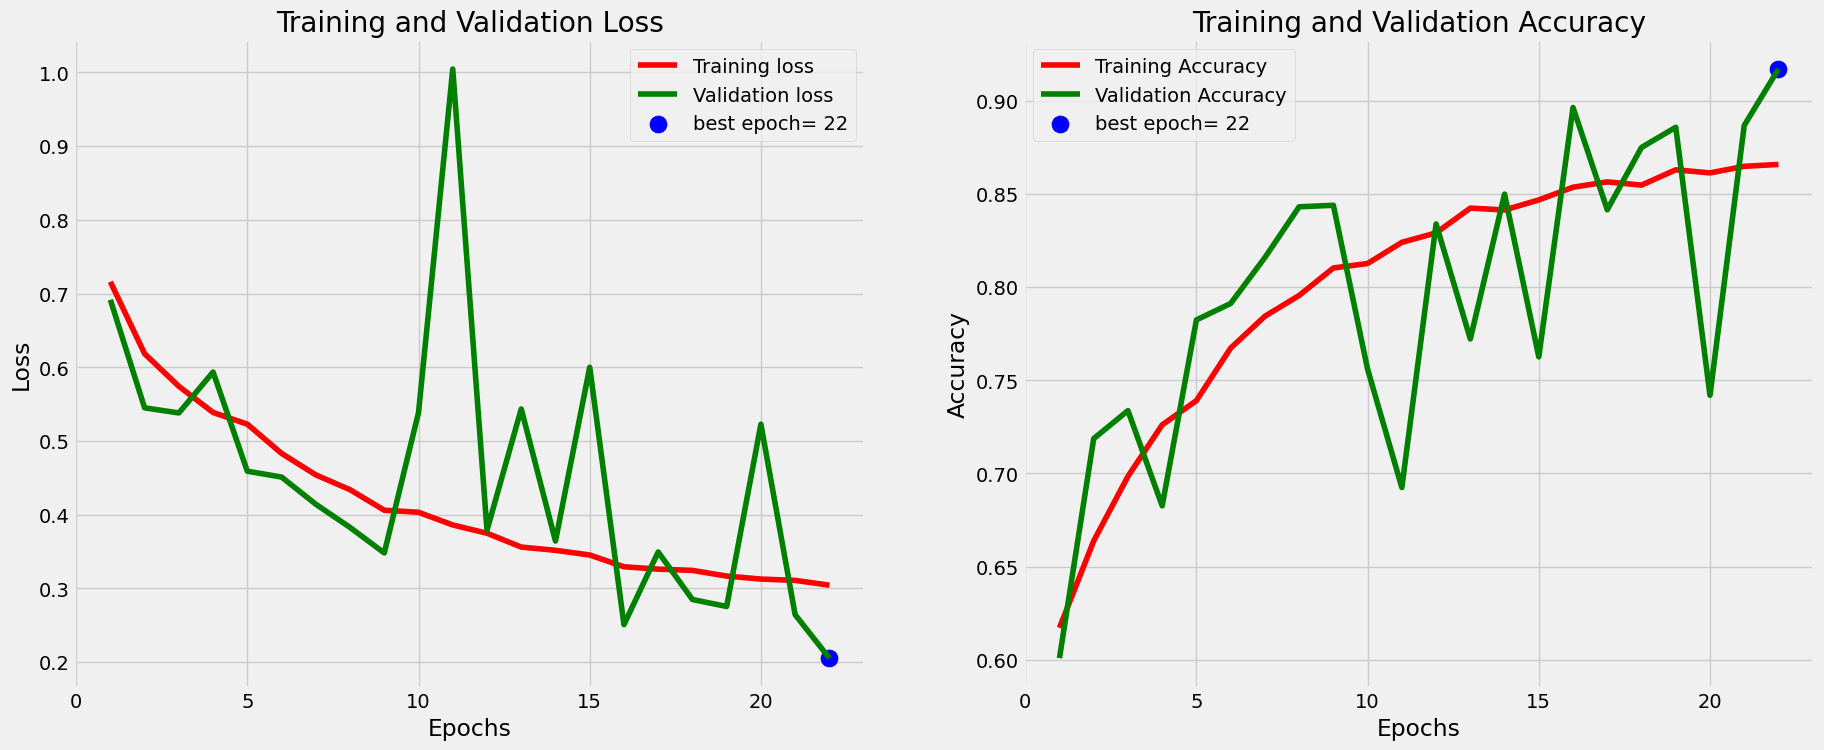

In [53]:
plot_history(history)

In [54]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step


In [55]:
from sklearn.metrics import *

print(classification_report(test_gen.classes, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2499
           1       0.94      0.91      0.93      2494

    accuracy                           0.93      4993
   macro avg       0.93      0.93      0.93      4993
weighted avg       0.93      0.93      0.93      4993



In [56]:
accuracy_score(test_gen.classes, y_pred)

0.9264970959343081

<Axes: >

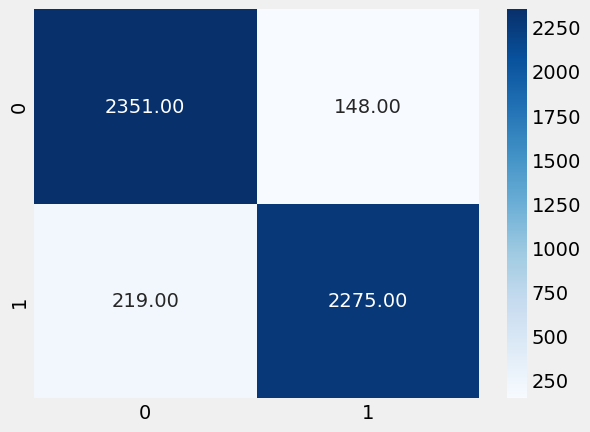

In [57]:
sns.heatmap(confusion_matrix(test_gen.classes,y_pred), cmap='Blues', annot=True, fmt='0.2f')

In [58]:
model.save("model2.h5")

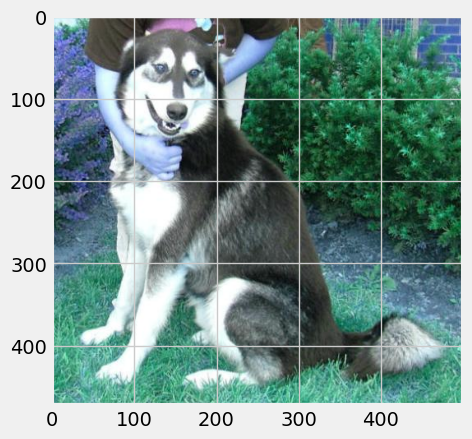

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Dog


In [59]:
predict_image(model,'/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/Dog/10021.jpg')

In [63]:
!pip install visualkeras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 21.3 MB/s eta 0:00:0000:01


In [65]:
import visualkeras

In [60]:
model1 = load_model('model1.h5')

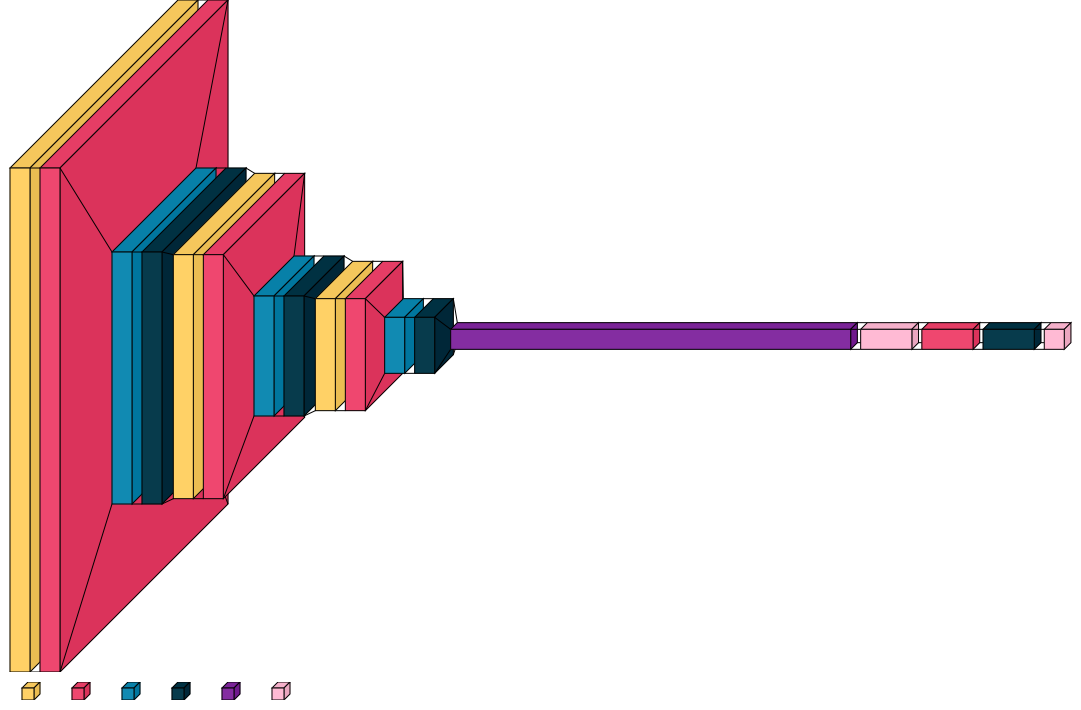

In [70]:
visualkeras.layered_view(model1, legend=True)

In [62]:
model2 = load_model('model2.h5')

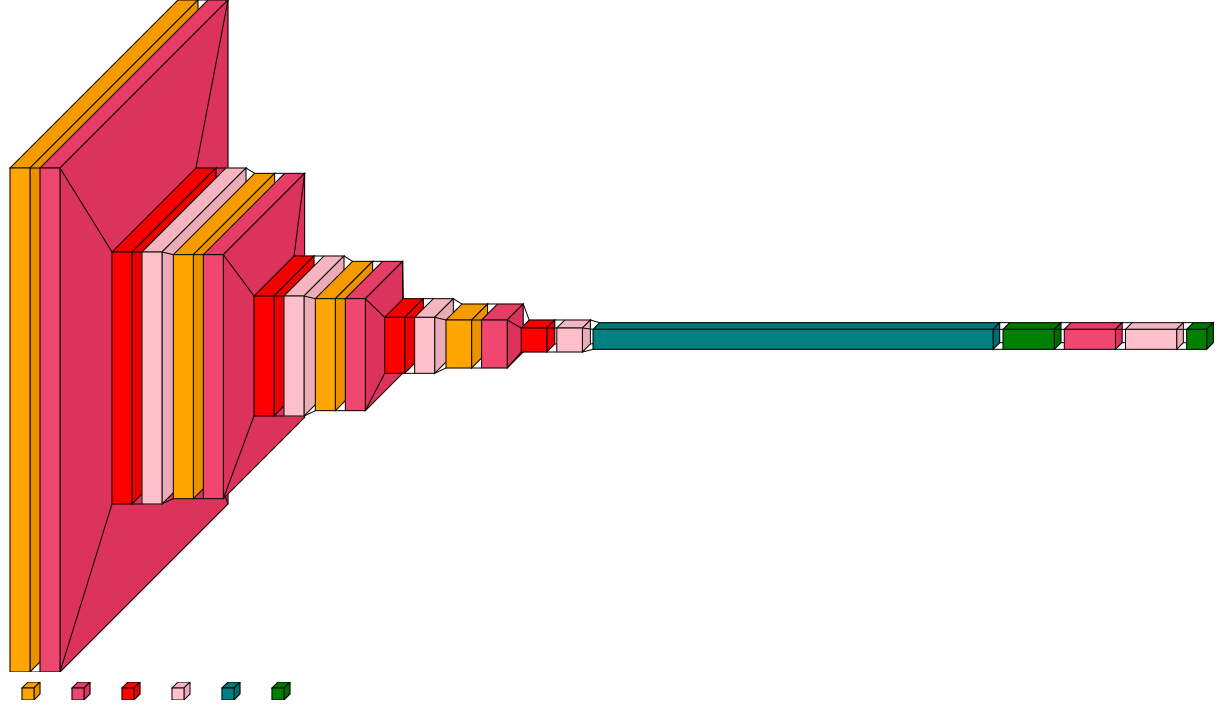

In [72]:
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model2,legend=True, color_map=color_map)
